# GZ Data Reduction: Binning & Cleaning

This notebook takes in raw (alpha level) Galaxy Zoo data and produces a binned output catalogue, a cleaned user-weighted output catalogue, and the associated user weights catalogue. 

Functions below are derived from [gz_reduce.py](https://github.com/bamford/gz_reduce/blob/master/gz_reduce.py) and [gz_reduce_gama_combined_clean.py](https://github.com/bamford/gz_reduce/blob/master/gz_reduce_gama_combined_clean.py), produced by Steven Bamford. Original cleaning efforts can also be found [on Dropbox](https://www.dropbox.com/sh/sd6meqzm8rktxfd/AABRfLFNJtrzolQKqFnnD3tfa?dl=0).

In [1]:
# imports
import os
import sys
import warnings
import math
import numpy as np
from numpy import ma
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from collections import Counter
import scipy.stats as st
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic, gaussian_kde
from scipy.optimize import minimize, curve_fit
import copy
import astropy.stats as stats
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import (Table, hstack, join, vstack,
                           Column, MaskedColumn)
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import imageio
import time
import string
import gzip
import re
import json

# startup
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
def timecheck(start = None, timefmt = '%Y-%m-%d %H:%M:%S %Z'):
    now = time.time()
    out = time.strftime(timefmt, time.localtime(now))
    if start:
        diff = time.strftime('%H:%M:%S', time.gmtime(now-start))
        out += f' (elapsed: {diff})'
    return [now, out]
nbt0, nbt0str = timecheck()
print(f'Notebook start time:\n   {nbt0str}')
#--------------------------------68-------------------------------->

Notebook start time:
   2020-10-27 16:01:05 CDT


## Config

In [2]:
# setup
tree = 'gama'
plot_label = 'gkgz'  # label = 'gama_combined_2018-02-25'
alpha_name = '../gkgz-alpha.fits.gz'
binned_name = '../gkgz-binned.fits.gz'
cleaned_name = '../gkgz-cleaned.fits.gz'
extra_name = '../gkgz-extra.fits.gz'
user_weights_name = '../gkgz-user_weights.fits.gz'
save_outputs = True  # save binned, cleaned & user_weights?
consistency_thresh = 0.75  # threshold for user downweighting
consistency_weight = 10  # power exponent for downweighting dropoff
user = 'user_id'
extra_id_names = ['CATAID', 'zooniverse_id']

## Fns from: `gz_reduce.py`

In [3]:
def parse_tree(stub):
    """Parse a Galaxy Zoo coffeescript tree description file."""
    questions = []
    answers = []
    letters = string.ascii_lowercase
    f = open('{}_tree.coffee'.format(stub))
    for l in f:
        ls = l.strip().split(',')
        if len(ls) > 0:
            lss_full = ls[0].replace('"', '').replace("'", "")
            lss = lss_full.split(maxsplit=1)
        if len(lss) > 1:
            test = lss[0].startswith
            value = lss[1].lower().replace(' ', '_')
            if test('@question'):
                qi = 0
                if value in questions:
                    questions[questions.index(value)] += '_a'
                while '{}_{}'.format(value,
                                     letters[qi]) in questions:
                    qi += 1
                if qi > 0:
                    value = '{}_{}'.format(value, letters[qi])
                questions.append(value)
                answers.append([])
            elif test('@checkbox'):
                answers[-1].append((value, 'x'))
            elif test('@answer'):
                if value != 'done':
                    answers[-1].append((value, 'a'))
    return questions, answers

In [4]:
def count_matches(col, test, group=None, anywhere=True, weights=1):
    """Count the matches of `test` in `col` grouped by `group`
       If `group` is `None`, return `True` for matches."""
    if anywhere:
        matches = np.zeros(len(col), np.bool)
        matches[~col.mask] = np.array([test in x.split(';')
                                       for x in col[~col.mask]])
    else:
        matches = col == test
    if group is not None:
        matches = matches * weights
        matches = Column(matches).group_by(group)
        count = matches.groups.aggregate(np.sum)
        return count
    else:
        return matches

In [5]:
def collate_classifications(indata, stub, questions, answers):
    """Reduce a GZ classification DB dump to a vote frac. table"""
    outdata = Table()
    outdata['subject_id'] = np.unique(indata['subject_id'])
    qindex = 0
    if 'weight' in indata.colnames:
        weights = indata['weight'].filled(0)
    else:
        weights = 1
    for cc in indata.columns:
        if cc.startswith(stub):
            qq = questions[qindex]
            outcols = Table()
            for aindex, (aa, qtype) in enumerate(answers[qindex]):
                test = '{}-{}'.format(qtype, aindex)
                count = count_matches(indata[cc], test,
                                      indata['subject_id'],
                                      anywhere=(qtype == 'x'),
                                      weights=weights)
                name = '{}_{}'.format(qq, aa)
                outcols[name] = count
                if aindex == 0:
                    total = count
                else:
                    total += count
            name = '{}_total'.format(qq)
            outdata[name] = total
            outdata = hstack([outdata, outcols])
            qindex += 1
    return outdata

In [6]:
def recalculate_odd_total(data):
    """Adjust for skipping odd Q without providing any answer."""
    data = data.copy()
    if 'odd_total' in data.colnames:
        data['odd_total'] = (data['features_total'] -
                             data['features_star_or_artifact'])
    if 'oddtype_total' in data.colnames:
        data['oddtype_total'] = (data['features_total'] -
                                 data['features_star_or_artifact'])
    return data

In [7]:
def calculate_fractions(data, questions, answers,
                        remove_counts=True):
    """Reduce a GZ classification DB dump to table of vote fracs."""
    data = data.copy()
    for qindex in range(len(questions)):
        qq = questions[qindex]
        for aindex, (aa, qtype) in enumerate(answers[qindex]):
            name = '{}_{}'.format(qq, aa)
            totalname = '{}_total'.format(qq)
            fracname = '{}_frac'.format(name)
            data[fracname] = data[name] / data[totalname]
            if remove_counts:
                data.remove_column(name)
    return data

In [8]:
# def read_subjects(infile, stub, survey_id_field):
#     """Parse an Ouroboros subject table dump to get useful ids."""
#     subject_id = []
#     survey_id = []
#     zooniverse_id = []
#     # tmp = ''
#     for line in gzip.open(infile):
#         line = line.decode("utf-8")
#         # # fix corruption (if nec. - match cleaned ver. by Lee)
#         # if re.search('ouroboros', line) is not None:
#         #     tmp += re.sub('2017-03.*ouroboros.*', '', line)[:-1]
#         #     continue
#         # if tmp != '':
#         #     line = tmp + line
#         #     tmp = ''
#         if re.search(stub, line) is not None:
#             ls = line.strip().split(',', maxsplit=3)
#             match = re.match('ObjectId\((.+)\)', ls[0])
#             subject_id.append(match.group(1))
#             zooniverse_id.append(ls[1])
#             metadata = ls[3].replace('""', '"')[1:-1]
#             metadata = json.loads(metadata)
#             if survey_id_field in metadata.keys():
#                 survey_id.append(metadata[survey_id_field])
#             else:
#                 survey_id.append(None)
#     subjects = Table([np.array(subject_id),
#                       np.array(survey_id, dtype=np.str),
#                       np.array(zooniverse_id)],
#                      names=('subject_id', 'survey_id',
#                             'zooniverse_id'))
#     return subjects

In [9]:
# def reduce_data(date, tree='gama', subjectset='gama09',
#                 survey_id_field='provided_image_id',
#                 subjectcat='galaxy_zoo_subjects_lee.csv.gz',
#                 subjectstub=None):
#     """Do everything to produce reduced ids/vote frac table."""
#     questions, answers = parse_tree(tree)
#     template = '{}_galaxy_zoo_{}_classifications.csv'
#     indata = Table.read(template.format(date, subjectset),
#                         fast_reader=False)
#     outdata = collate_classifications(indata, tree,
#                                       questions, answers)
#     outdata = recalculate_odd_total(outdata)
#     outdata = calculate_fractions(outdata, questions, answers)
#     if subjectstub is None:
#         subjectstub = subjectset
#     subjects = read_subjects(subjectcat, subjectstub,
#                              survey_id_field)
#     outdata = join(outdata, subjects, 'subject_id')
#     return outdata

## Fns from: `gz_reduce_gama_combined_clean.py`

In [10]:
def evaluate_data(indata, outdata, stub, user='user'):
    data = join(indata, outdata,
                keys='subject_id', join_type='left')
    evaluation = data[['subject_id', user, 'weight']]
    evaluation['consistency'] = ma.masked_array(0.0)
    evaluation['agreement'] = ma.masked_array(0.0)
    nanswered = np.zeros(len(data), np.int)
    qindex = 0
    for cc in indata.columns:
        if cc.startswith(stub):
            qq = questions[qindex]
            # skip oddtype/discuss questions from further analysis
            if ('odd' in qq) or ('discuss' in qq):
                qindex += 1
                continue
            tname = '{}_total'.format(qq)
            total = data[tname]
            consistency = np.zeros(len(data))
            crossentropy = np.zeros(len(data))
            answered = np.zeros(len(data), np.bool)
            for aindex, (aa, qtype) in enumerate(answers[qindex]):
                # print(qindex, qq, aindex, aa)
                test = '{}-{}'.format(qtype, aindex)
                match = count_matches(data[cc], test,
                                      anywhere=(qtype == 'x'))
                if qindex == 0 and aindex == 2:
                    artifact = np.where(match, 1, 0)
                    ###!!!### continue  # ignore artifact answers
                answered |= match
                name = '{}_{}'.format(qq, aa)
                fname = '{}_frac'.format(name)
                pp = data[fname]
                consistencyi = np.where(match, pp, 1 - pp)
                total = total.clip(min=1)
                minprob = 0.1 / total
                pp = pp.clip(min=minprob)  # bound the min. prob.
                crossentropyi = -np.where(match, 1, 0) * np.log(pp)
                consistency += consistencyi
                crossentropy += crossentropyi
                # LSK commented out below, as repeat of above
                # if qindex == 0 and aindex == 2:
                #     artifact = np.where(match, 1, 0)
            nqanswers = len(answers[qindex])
            consistency /= nqanswers
            agreement = (1 - crossentropy) / np.log(nqanswers)
            # ignore and mask questions that are not answered
            consistency[~answered] = 0
            agreement[~answered] = 0
            name = '{}_consistency'.format(qq)
            evaluation[name] = ma.masked_array(consistency)
            evaluation['consistency'] += evaluation[name]
            evaluation[name].mask = ~answered
            name = '{}_agreement'.format(qq)
            evaluation[name] = ma.masked_array(agreement)
            evaluation['agreement'] += evaluation[name]
            evaluation[name].mask = ~answered
            nanswered += np.where(answered, 1, 0)
            qindex += 1
    # ignoring odd & discuss, must have answered at least 1 question
    # clip below corrects nanswered=0 to 1, catching unusual entries
    nanswered = nanswered.clip(min=1)
    evaluation['nanswered'] = ma.masked_array(nanswered)
    evaluation['consistency'] /= nanswered
    evaluation['agreement'] /= nanswered
    evaluation['artifact'] = ma.masked_array(artifact)
    evaluation = evaluation.group_by(user)
    evaluation_user = evaluation.groups.aggregate(ma.mean)
    evaluation['count'] = ma.masked_array(1)
    user_count = evaluation[user, 'count', 'weight',
                            'artifact'].groups.aggregate(ma.sum)
    evaluation_user['count_unweighted'] = user_count['count']
    evaluation_user['count'] = user_count['weight']
    evaluation_user['artifact_fraction'] = (user_count['artifact'] /
                                            user_count['count'])
    evaluation_user.sort('consistency')
    return evaluation, evaluation_user

In [11]:
def stripnan(x):
    return x[~np.isnan(x)]

In [12]:
def evaluation_plots(eval_user,
                     title = '', figsize = (8,10), dpi = 150):

    fig, axarr = plt.subplots(3, 2, figsize=figsize, dpi=dpi)
    axarr = axarr.flat

    ax = axarr[0]
    for q in questions:
        name = '{}_consistency'.format(q)
        if name in eval_user.colnames:
            ax.hist(stripnan(eval_user[name]), label=q, log=True,
                    histtype='step', range=(0, 1), bins=25)
    ax.hist(eval_user['consistency'], label='total', log=True,
            histtype='step', color='k', lw=3, range=(0, 1), bins=25)
    ax.set_xlabel('consistency')
    ax.vlines(0.75, 0.1, 3000, linestyles='dotted')
    ax.set_xlim(0.0, 1.0)
    ax.legend(fontsize='xx-small')

    ax = axarr[1]
    for q in questions:
        name = '{}_agreement'.format(q)
        if name in eval_user.colnames:
            ax.hist(stripnan(eval_user[name]), label=q, log=True,
                    histtype='step', range=(-6, 3), bins=25)
    ax.hist(eval_user['agreement'], label='total', histtype='step',
            color='k', lw=3, log=True,
            range=(-6, 3), bins=25)
    ax.set_xlabel('agreement')
    ax.vlines(0.0, 0.1, 3000, linestyles='dotted')
    ax.set_xlim(-6, 3)
    ax.legend(fontsize='xx-small')

    ax = axarr[2]
    ax.scatter(eval_user['consistency'], eval_user['agreement'],
               marker='.', alpha=0.5, edgecolor='none',
               c=np.log10(eval_user['count']), vmin=-1, vmax=5)
    ax.set_xlim(0.4, 0.9)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('consistency')
    ax.set_ylabel('agreement')

    ax = axarr[3]
    ax.hist(np.log10(eval_user['count']))
    ax.set_xlim(-1, 5)
    ax.set_xlabel('$\log_{10}(count)$')

    ax = axarr[4]
    ax.scatter(np.log10(eval_user['count']),
               eval_user['consistency'],
               marker='.', alpha=0.5, edgecolor='none',
               c=np.log10(eval_user['count']), vmin=-1, vmax=5)
    ax.hlines(0.75, -0.25, 4.5)
    ax.set_xlim(-1, 5)
    ax.set_ylim(0.4, 0.9)
    ax.set_xlabel('$\log_{10}(count)$')
    ax.set_ylabel('consistency')

    ax = axarr[5]
    ax.scatter(np.log10(eval_user['count']), eval_user['agreement'],
               marker='.', alpha=0.5, edgecolor='none',
               c=np.log10(eval_user['count']), vmin=-1, vmax=5)
    ax.hlines(0, -0.25, 4.5)
    ax.set_xlim(-1, 5)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$\log_{10}(count)$')
    ax.set_ylabel('agreement')

    #ax.set_axis_off()
    fig.text(0.53, 0.985, title, ha='center', va='top',
             transform=fig.transFigure, fontsize='large')
    plt.tight_layout(rect=(0,0,1,0.97))

In [13]:
def iterate_stage(stage, indata, outdata, questions, answers, tree,
                  plot_label, eval_user = None, user = 'user'):
    
    # only set weights if eval_user already exists
    if eval_user:
        new_wt = ((eval_user['consistency'] /
                   consistency_thresh)**consistency_weight)
        eval_user['weight'] = new_wt.clip(max=1)
        user_weight = Table(eval_user[user, 'weight'], masked=False)
        indata.remove_column('weight')
        indata = join(indata,user_weight,join_type='left',keys=user)
        outdata = collate_classifications(indata, tree,
                                          questions, answers)
        outdata = recalculate_odd_total(outdata)
        outdata = calculate_fractions(outdata, questions, answers)
    
    # evaluate primary dataset
    eval_tab, eval_user = evaluate_data(indata, outdata, tree, user)
    eval_user_avg = eval_user.groups.aggregate(np.nanmean)
    evaluation_plots(eval_user, f'evaluation stage {stage}')
    plt.savefig(f'{plot_label}_evaluation_stage{stage}.pdf',
                dpi = 'figure')
    plt.close()

    # evaluate shuffled dataset
    outshuffle = outdata.copy()
    perm = np.random.permutation(len(outdata))
    outshuffle['subject_id'] = outshuffle['subject_id'][perm]
    shuf_tab, shuf_user = evaluate_data(indata,outshuffle,tree,user)
    shuf_user_avg = shuf_user.groups.aggregate(np.nanmean)
    evaluation_plots(shuf_user, f'evalshuffle stage {stage}')
    plt.savefig(f'{plot_label}_evalshuffle_stage{stage}.pdf',
                dpi = 'figure')
    plt.close()
    
    return (indata, outdata,
            eval_tab, eval_user, eval_user_avg,
            shuf_tab, shuf_user, shuf_user_avg)

## Establish Question/Answer Decision Tree

In [14]:
# get questions/answers from original GAMA CoffeeScript
questions, answers = parse_tree(tree)
display(dict(zip(questions, answers)))

{'features': [('smooth', 'a'), ('features', 'a'), ('star_or_artifact', 'a')],
 'edgeon': [('yes', 'a'), ('no', 'a')],
 'bar': [('bar', 'a'), ('no_bar', 'a')],
 'spiral': [('spiral', 'a'), ('no_spiral', 'a')],
 'bulge': [('no_bulge', 'a'), ('obvious', 'a'), ('dominant', 'a')],
 'spiralwinding': [('tight', 'a'), ('medium', 'a'), ('loose', 'a')],
 'spiralnumber': [('1', 'a'),
  ('2', 'a'),
  ('3', 'a'),
  ('4', 'a'),
  ('more_than_4', 'a')],
 'bulgeshape': [('rounded', 'a'), ('boxy', 'a'), ('no_bulge', 'a')],
 'round': [('completely_round', 'a'),
  ('in_between', 'a'),
  ('cigar_shaped', 'a')],
 'mergers': [('merging', 'a'),
  ('tidal_debris', 'a'),
  ('both', 'a'),
  ('neither', 'a')],
 'oddtype': [('none', 'x'),
  ('ring', 'x'),
  ('lens_or_arc', 'x'),
  ('irregular', 'x'),
  ('other', 'x'),
  ('dust_lane', 'x'),
  ('overlapping', 'x')],
 'discuss': [('yes', 'a'), ('no', 'a')]}

## Read In Raw Data and Prepare

In [15]:
# read in raw (alpha) data
indata_unmasked = Table.read(alpha_name)
indata = Table(indata_unmasked, masked=True)
indata['weight'] = MaskedColumn(np.ones(len(indata)))

In [16]:
# raw data preview
display(indata[0:2].to_pandas().T)

,0,1
id,b'588f50c17d25c730ea00018c',b'588f51777d25c76f920000e5'
subject_id,b'5857c531d369fd0040005911',b'5857c532d369fd00400059df'
user_id,17536,-2969
created_at,b'2017-01-30 14:42:09 UTC',b'2017-01-30 14:45:11 UTC'
lang,b'en ',b'ru '
user_agent,b'unknown ',b'unknown '
gama-0,b'a-1 ',b'a-1 '
gama-1,b'a-0',b'a-0'
gama-2,b' ',b' '
gama-3,b' ',b' '


In [17]:
%%time
# strip whitespace from answer data columns
rawdata = indata.copy()
for cc in rawdata.columns:
    if cc.startswith(tree):
        print(cc, end=' ')
        col = rawdata[cc]
        rawdata[cc] = ma.masked_array([x.strip(' ') for x in col])
print('')

gama-0 gama-1 gama-2 gama-3 gama-4 gama-5 gama-6 gama-7 gama-8 gama-9 gama-10 gama-11 
CPU times: user 8min 10s, sys: 3.78 s, total: 8min 14s
Wall time: 8min 13s


## Raw Data Statistics

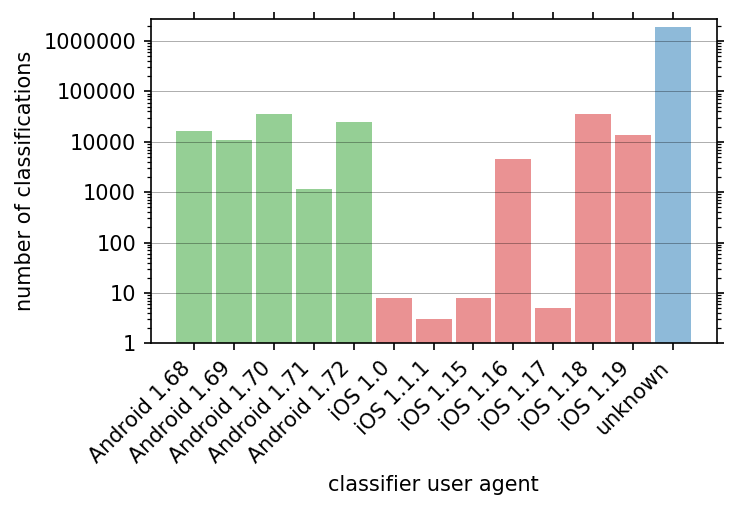

In [18]:
# user agents
user_agents = Counter(rawdata['user_agent'])
user_agents = dict(sorted(user_agents.items()))
ua_fmt = {}
ua_col = []
for ua in user_agents:
    bits = ua.strip(' ').split('/')
    if 'android' in ua:
        name = f'Android {bits[-1]}'
        ua_col.append(2)
    elif 'ios' in ua:
        name = f'iOS {bits[-1]}'
        ua_col.append(3)
    else:
        name = bits[-1]
        ua_col.append(0)
    ua_fmt.update({name:user_agents[ua]})
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=150)
ax.bar(ua_fmt.keys(), ua_fmt.values(), log=True,
       width=0.9, color=cmap(ua_col), alpha=0.5)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: int(x)))
ax.tick_params(which='both',
               top=True, bottom=True, left=True, right=True)
ax.set_ylim((1, np.max(list(ua_fmt.values()))*1.5))
[ax.axhline(y,c='k',lw=0.3,alpha=0.5) for y in 10**np.arange(1,9,1)]
ax.set_xlabel('classifier user agent')
ax.set_ylabel('number of classifications')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(fname='stat_user_agent.pdf', dpi='figure')
plt.show()
plt.close()

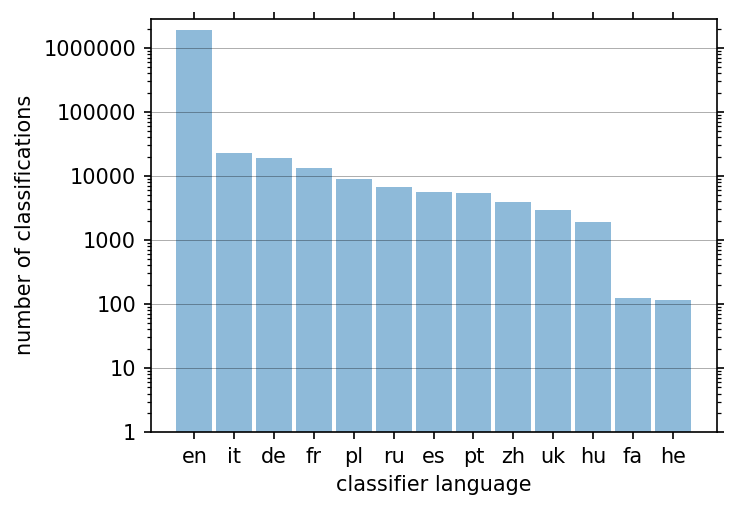

In [19]:
# language
lang_copy = copy.copy(rawdata['lang'])
# merge zh variants
zh_variant = ['zh-tw', 'zh_cn', 'zh_tw']
for zh in zh_variant:
    lang_copy[lang_copy == zh] = 'zh   '
lang = Counter(lang_copy)
# lang = dict(sorted(lang.items()))  # sort by key
lang = {k:v for k,v in sorted(lang.items(), key=lambda item:item[1],
                              reverse=True)}
lang_codes = [x.strip(' ') for x in list(lang.keys())]
fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=150)
ax.bar(lang_codes, lang.values(), log=True,
       width=0.9, alpha=0.5)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: int(x)))
ax.tick_params(which='both',
               top=True, bottom=True, left=True, right=True)
ax.set_ylim((1, np.max(list(lang.values()))*1.5))
[ax.axhline(y,c='k',lw=0.3,alpha=0.5) for y in 10**np.arange(1,9,1)]
ax.set_xlabel('classifier language')
ax.set_ylabel('number of classifications')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(fname='stat_user_lang.pdf', dpi='figure')
plt.show()
plt.close()

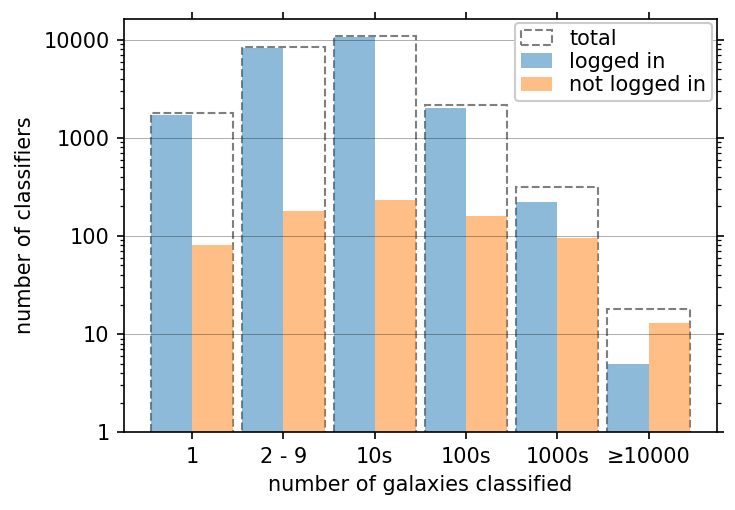

In [20]:
# number of galaxies classified per user (logged in version)
nums_unsorted = Counter(rawdata[user])
nums = {k:v for k,v in sorted(nums_unsorted.items(),
                              key=lambda item:item[1],reverse=True)}
nums_li = {k:v for k,v in nums.items() if k > 0}
nums_nli = {k:v for k,v in nums.items() if k < 0}
bins = np.append([0, 2], 10**np.arange(1, 6, 1))
# nums_mids = [str(bins[i-1])+' - '+str(bins[i]-1)
#              for i in range(2,len(bins)-1)]
nums_mids = [str(bins[i])+'s' for i in range(2,len(bins)-2)]
nums_code = np.hstack((np.array(('1','2 - 9')), nums_mids,
                       '≥'+str(bins[-2])))
nums_hist, _ = np.histogram(list(nums.values()), bins=bins)
nums_hist_li, _ = np.histogram(list(nums_li.values()), bins=bins)
nums_hist_nli, _ = np.histogram(list(nums_nli.values()), bins=bins)
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=150)
ax.bar(nums_code, nums_hist, log=True, width=0.9, alpha=0.5,
       label='total', fill=False, edgecolor='k', linestyle='--')
ax.bar(nums_code, nums_hist_li, log=True, width=-0.45, alpha=0.5,
       align='edge', fill=True, color=cmap(0),
       label='logged in')
ax.bar(nums_code, nums_hist_nli, log=True, width=0.45, alpha=0.5,
       align='edge', fill=True, color=cmap(1),
       label='not logged in')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: int(x)))
ax.tick_params(which='both',
               top=True, bottom=True, left=True, right=True)
ax.set_ylim((1, np.max(nums_hist)*1.5))
[ax.axhline(y,c='k',lw=0.3,alpha=0.5) for y in 10**np.arange(1,9,1)]
ax.set_xlabel('number of galaxies classified')
ax.set_ylabel('number of classifiers')
ax.legend(fontsize='medium', handlelength=1.5, borderpad=0.3,
          labelspacing=0.15, borderaxespad=0.2, framealpha=1)
# plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(fname='stat_numclass_logged.pdf', dpi='figure')
plt.show()
plt.close()

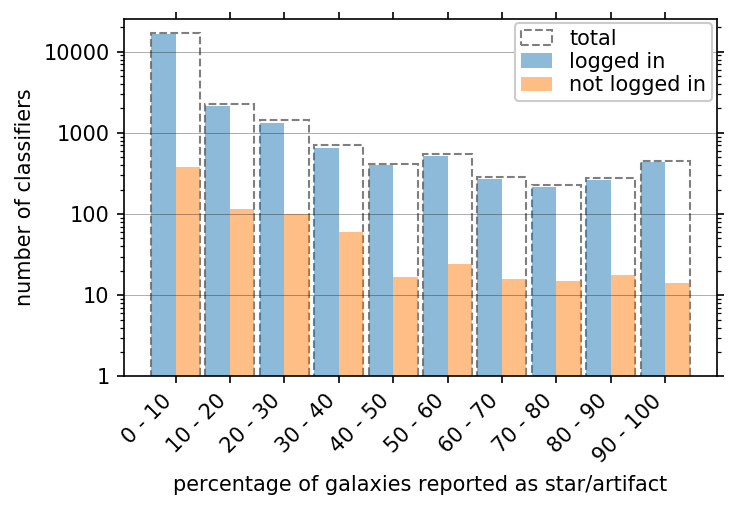

In [21]:
# star/artifact percentage
qq = 'gama-0'
aa = 'a-2'
nums_total = dict(Counter(rawdata[user]))
nums_artifact = dict(Counter(rawdata[user][rawdata[qq] == aa]))
nums_artifrac = {k:(nums_artifact[k] / nums_total[k]
                    if k in nums_artifact else 0)
                 for k,v in nums_total.items()}
nums_artifrac_li = {k:v for k,v in nums_artifrac.items() if k > 0}
nums_artifrac_nli = {k:v for k,v in nums_artifrac.items() if k < 0}
bins = np.arange(0,1.001,0.1)
# fracs = [str(round(bins[i-1],1)) + ' - ' + str(round(bins[i],1))
#          for i in range(1, len(bins))]
fracs = [str(int(bins[i-1]*100))+' - '+str(int(bins[i]*100))
         for i in range(1, len(bins))]
bin_total = np.histogram(list(nums_artifrac.values()), bins=bins)
bin_li = np.histogram(list(nums_artifrac_li.values()), bins=bins)
bin_nli = np.histogram(list(nums_artifrac_nli.values()), bins=bins)
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=150)
ax.bar(fracs, bin_total[0], log=True, width=0.9, alpha=0.5,
       label='total', fill=False, edgecolor='k', linestyle='--')
ax.bar(fracs, bin_li[0], log=True, width=-0.45, alpha=0.5,
       align='edge', fill=True, color=cmap(0),
       label='logged in')
ax.bar(fracs, bin_nli[0], log=True, width=0.45, alpha=0.5,
       align='edge', fill=True, color=cmap(1),
       label='not logged in')
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: int(x)))
ax.tick_params(which='both',
               top=True, bottom=True, left=True, right=True)
ax.set_ylim((1, np.max(bin_total[0])*1.5))
[ax.axhline(y,c='k',lw=0.3,alpha=0.5) for y in 10**np.arange(1,9,1)]
ax.set_xlabel('percentage of galaxies reported as star/artifact')
ax.set_ylabel('number of classifiers')
ax.legend(fontsize='medium', handlelength=1.5, borderpad=0.3,
          labelspacing=0.15, borderaxespad=0.2, framealpha=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(fname='stat_star_artifact.pdf', dpi='figure')
plt.show()
plt.close()

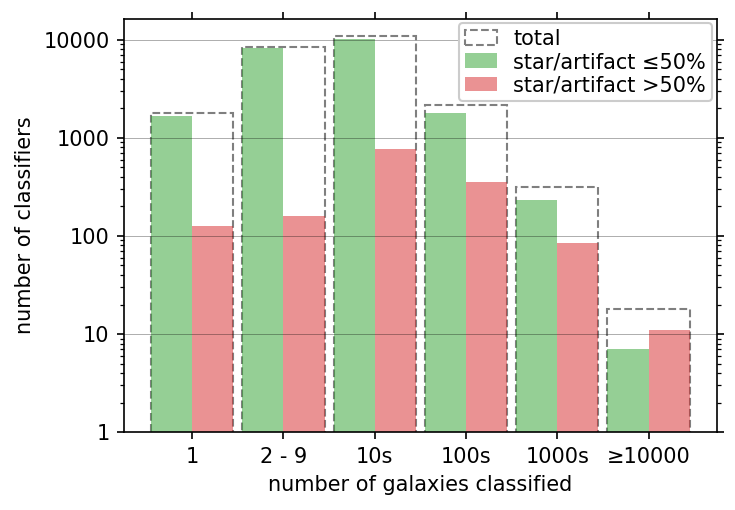

In [22]:
# number of galaxies classified per user (artifact version)
qq = 'gama-0'
aa = 'a-2'
nums_total = dict(Counter(rawdata[user]))
nums_artifact = dict(Counter(rawdata[user][rawdata[qq] == aa]))
nums_artifrac = {k:(nums_artifact[k] / nums_total[k]
                    if k in nums_artifact else 0)
                 for k,v in nums_total.items()}
lo_sa = [k for k,v in list(nums_artifrac.items()) if v <= 0.5]
hi_sa = [k for k,v in list(nums_artifrac.items()) if v > 0.5]
lo_total = {k:v for k,v in list(nums_total.items()) if k in lo_sa}
hi_total = {k:v for k,v in list(nums_total.items()) if k in hi_sa}
bins = np.append([0, 2], 10**np.arange(1, 6, 1))
nums_hist, _ = np.histogram(list(nums_total.values()), bins=bins)
nums_hist_lo, _ = np.histogram(list(lo_total.values()), bins=bins)
nums_hist_hi, _ = np.histogram(list(hi_total.values()), bins=bins)
nums_mids = [str(bins[i])+'s' for i in range(2,len(bins)-2)]
nums_code = np.hstack((np.array(('1','2 - 9')), nums_mids,
                       '≥'+str(bins[-2])))
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=150)
ax.bar(nums_code, nums_hist, log=True, width=0.9, alpha=0.5,
       label='total', fill=False, edgecolor='k', linestyle='--')
ax.bar(nums_code, nums_hist_lo, log=True, width=-0.45, alpha=0.5,
       align='edge', fill=True, color=cmap(2),
       label='star/artifact ≤50%')
ax.bar(nums_code, nums_hist_hi, log=True, width=0.45, alpha=0.5,
       align='edge', fill=True, color=cmap(3),
       label='star/artifact >50%')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, p: int(x)))
ax.tick_params(which='both',
               top=True, bottom=True, left=True, right=True)
ax.set_ylim((1, np.max(nums_hist)*1.5))
[ax.axhline(y,c='k',lw=0.3,alpha=0.5) for y in 10**np.arange(1,9,1)]
ax.set_xlabel('number of galaxies classified')
ax.set_ylabel('number of classifiers')
ax.legend(fontsize='medium', handlelength=1.5, borderpad=0.3,
          labelspacing=0.15, borderaxespad=0.2, framealpha=1)
# plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(fname='stat_numclass_artifact.pdf', dpi='figure')
plt.show()
plt.close()

In [23]:
# find unusual values in raw catalogue (client side caching issues?)
print('Unusual values in the raw catalogue:')
for ii, (qq, aa) in enumerate(zip(questions, answers)):
    colname = f'{tree}-{ii}'
    print(f'  {colname} ({qq}): ', end='')
    aa_allowed = [f'{aa[0][1]}-{i}' for i in np.arange(0,len(aa),1)]
    if aa_allowed[0] == 'x-0':
        aa_allowed.extend(['a-0', 'a-0;'])
    aa_allowed.append('')
    col = rawdata[colname]
    good_rows = [list((col == x).data) for x in aa_allowed]
    bad_rows = ~np.any(good_rows, axis=0)
    if np.sum(bad_rows) > 0:
        count = Counter(col[bad_rows])
    else:
        count = {}
    keys = list(count.keys())
    kstub = [x[:4] for x in keys]
    badkeys = [y for x, y in zip(kstub,keys) if x not in aa_allowed]
    badcount = {x:count[x] for x in badkeys}
    print(f'{badcount}')
    # took a look at the user agents assoc. with bad rows
    # all turn out to be type 'unknown'
    # print(f'{Counter(rawdata["user_agent"][bad_rows])}')

Unusual values in the raw catalogue:
  gama-0 (features): {'a-3': 4, 'a-0;x-5': 1}
  gama-1 (edgeon): {}
  gama-2 (bar): {}
  gama-3 (spiral): {}
  gama-4 (bulge): {}
  gama-5 (spiralwinding): {}
  gama-6 (spiralnumber): {}
  gama-7 (bulgeshape): {}
  gama-8 (round): {}
  gama-9 (mergers): {}
  gama-10 (oddtype): {'a-3': 17, 'a-1': 7, 'a-2': 3}
  gama-11 (discuss): {'a-2': 5}


## Run Binning Routines

In [24]:
%%time
# collate raw alpha classifications into binned results
bindata0 = collate_classifications(rawdata,tree,questions,answers)

CPU times: user 4min 48s, sys: 2.74 s, total: 4min 51s
Wall time: 4min 51s


In [25]:
# adjust odd total values: accounts for users skipping this question
bindata0 = recalculate_odd_total(bindata0)

In [26]:
# replace answer totals with fractions
with np.errstate(invalid='ignore'):
    bindata = calculate_fractions(bindata0, questions, answers)

In [27]:
# binned data preview
display(bindata.to_pandas()[0:2].T)

,0,1
subject_id,b'5857c4a3d369fd0040000001',b'5857c4a3d369fd0040000003'
features_total,40,40
edgeon_total,4,5
bar_total,4,4
spiral_total,4,4
bulge_total,4,4
spiralwinding_total,0,1
spiralnumber_total,0,1
bulgeshape_total,0,1
round_total,33,29


## Run Cleaning Routines

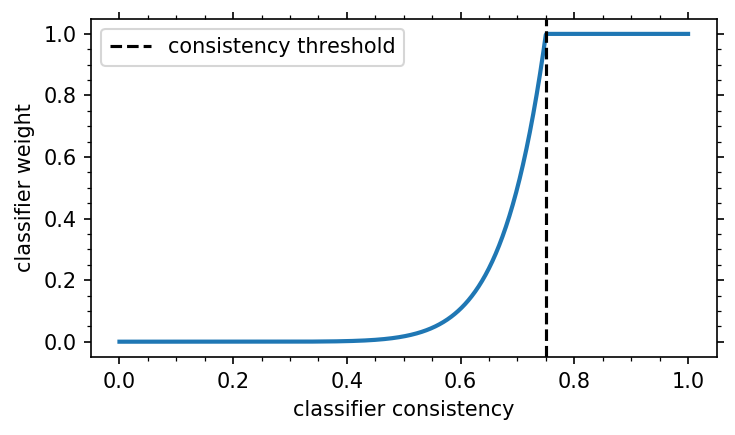

In [28]:
# construct consistency vs weight plot, for reference
plot_consistency = np.linspace(0.0, 1.0, 1000)
plot_conscale = plot_consistency / consistency_thresh
plot_weights = (plot_conscale**consistency_weight).clip(max=1)
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=150)
ax.plot(plot_consistency, plot_weights, lw=2)
ax.axvline(consistency_thresh, ls='--', c='k',
           label='consistency threshold')
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.minorticks_on()
ax.set_xlabel('classifier consistency')
ax.set_ylabel('classifier weight')
# ax.set_yscale('log')
ax.legend()
plt.tight_layout()
plt.savefig(f'{plot_label}_consistency_weight.pdf', dpi='figure')
plt.show()
plt.close()

In [29]:
# establish clean input datasets
indata = rawdata.copy()
outdata = bindata.copy()

In [30]:
%%time
# iterate user weights in 5 stages
eval_user = None
eval_tab_dict, eval_user_dict, clndata_dict = {}, {}, {}
for i in range(5):
    print(f'Running stage {i+1}')
    out = iterate_stage(i+1, indata, outdata, questions, answers,
                        tree, plot_label, eval_user, user=user)
    (indata, outdata, eval_tab, eval_user, eval_user_avg,
     shuf_tab, shuf_user, shuf_user_avg) = out
    # save snapshots for later analysis
    eval_tab_dict[i+1] = copy.copy(eval_tab)
    eval_user_dict[i+1] = copy.copy(eval_user)
    clndata_dict[i+1] = copy.copy(outdata)

Running stage 1


/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/astropy/table/groups.py:259: UserWarning: Warning: converting a masked element to nan.
  vals = np.array([func(par_col[i0: i1]) for i0, i1 in zip(i0s, i1s)])
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Running stage 2


/software/lsstsw/stack_20200515/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Running stage 3
Running stage 4
Running stage 5
CPU times: user 53min 45s, sys: 51.8 s, total: 54min 37s
Wall time: 46min 55s


## Post-Cleaning Analysis Plots

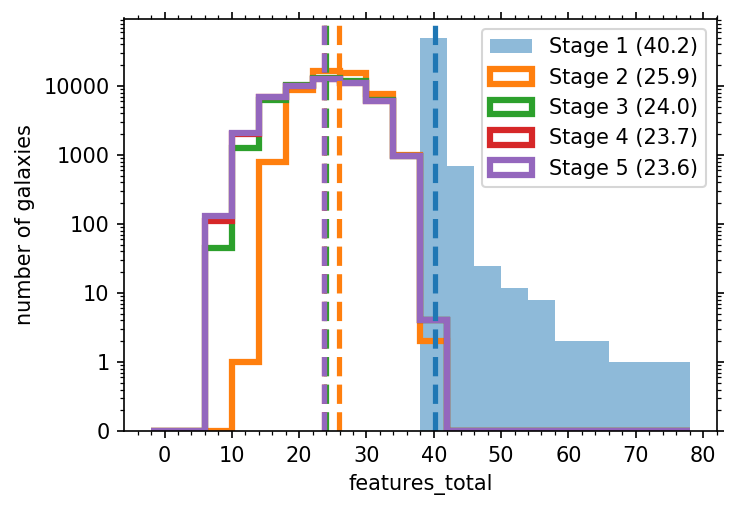

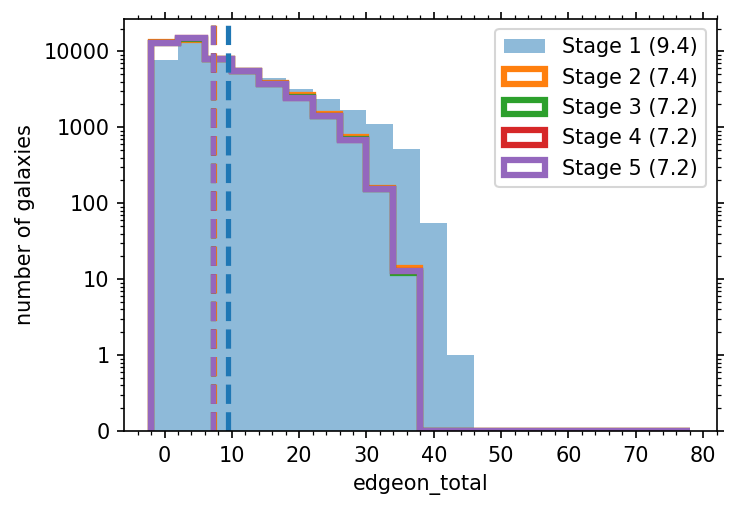

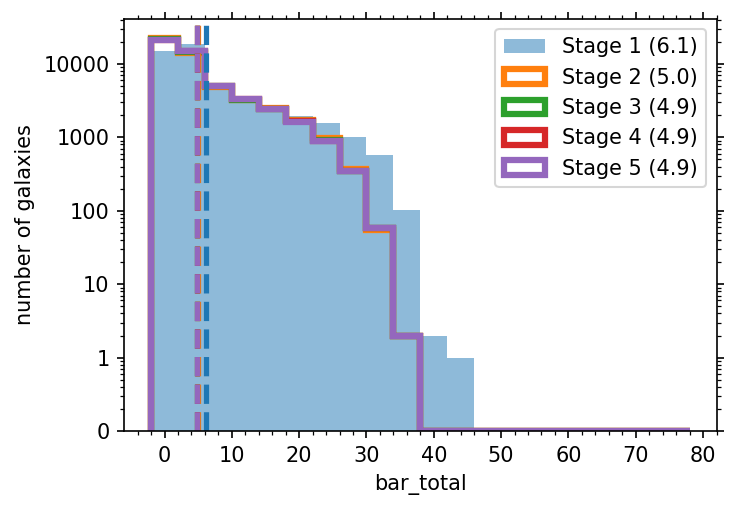

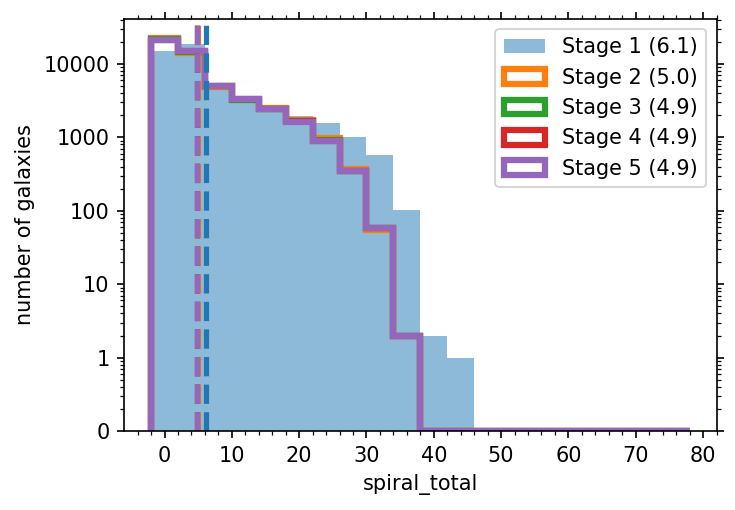

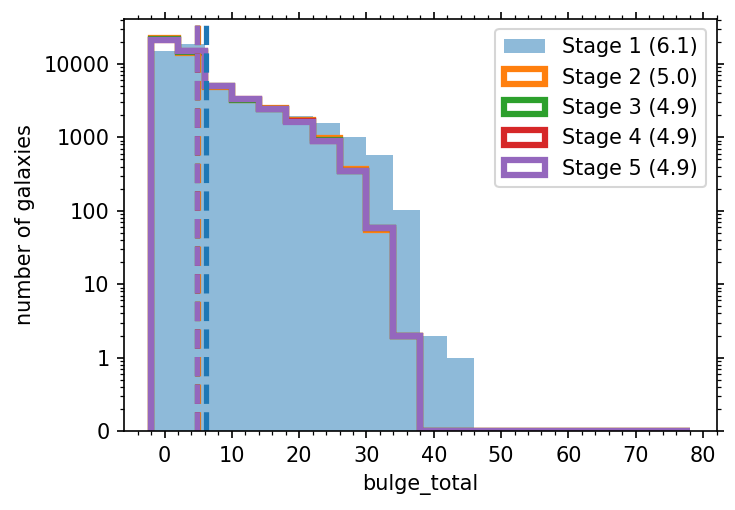

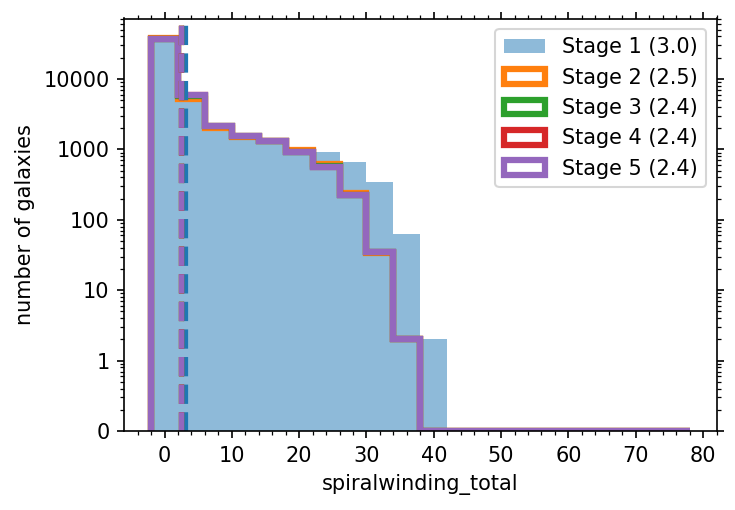

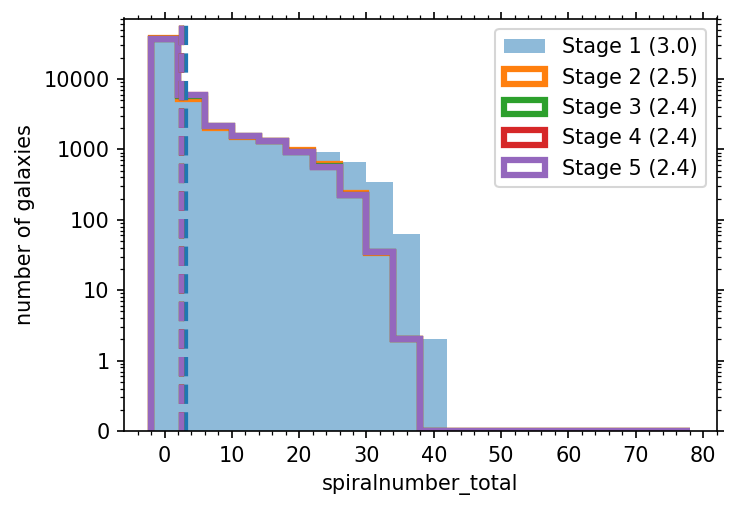

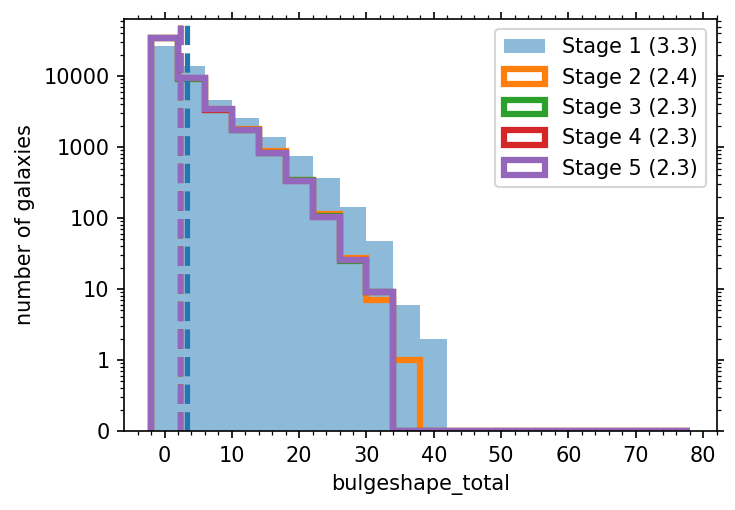

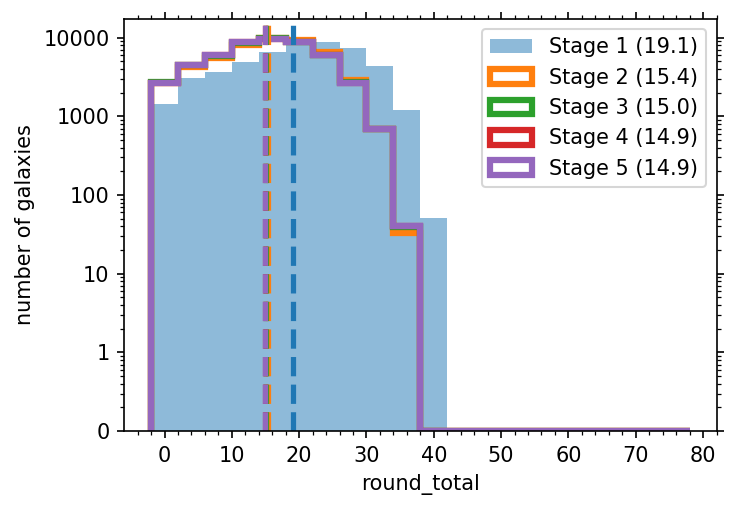

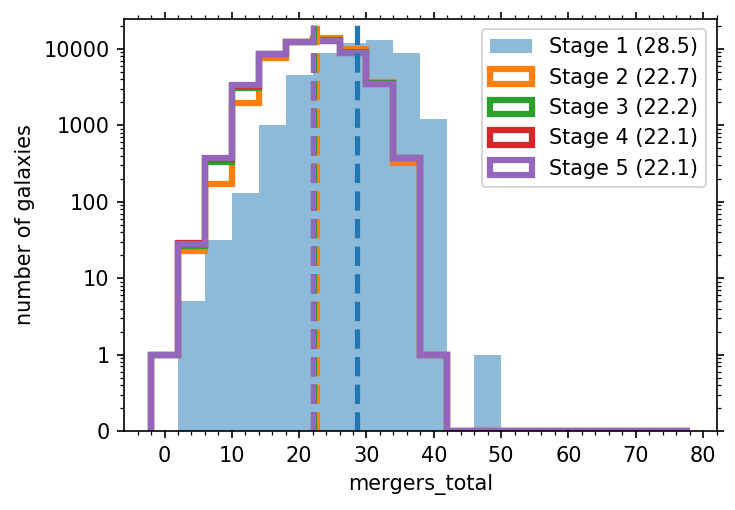

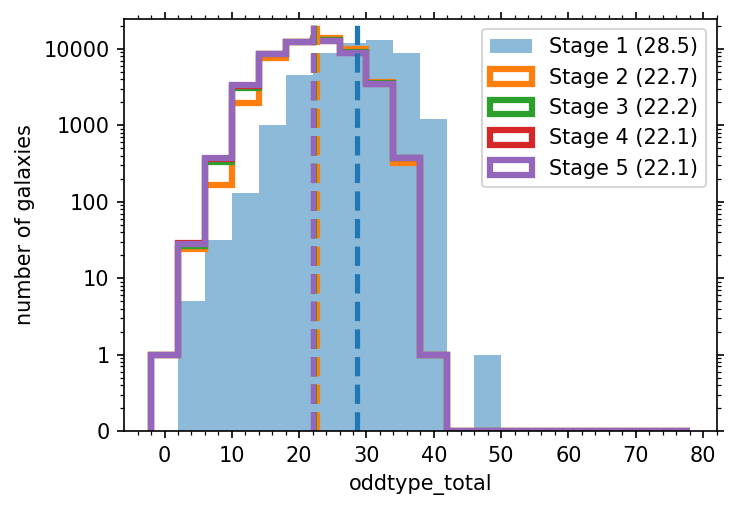

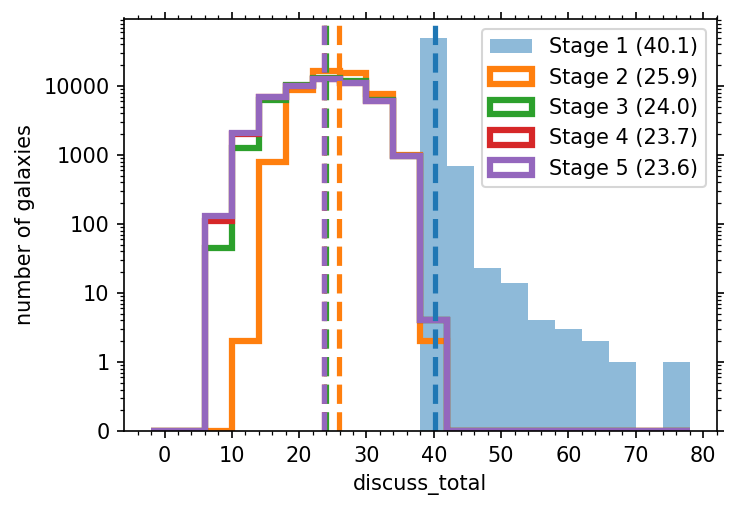

In [31]:
# total user counts as a function of cleaning stage for all Qs
cmap = plt.get_cmap('tab10')
colnames = [x for x in clndata_dict[1].columns if '_total' in x]
bins = np.arange(-2, 80, 4)
# bins = np.logspace(np.log10(1), np.log10(90), 15)
for colname in colnames:
    fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=150)
    hstat = []
    for i in range(len(clndata_dict)):
        ht = 'bar' if i == 0 else 'step'
        al = 0.5 if i == 0 else 1
        hvals, hbins, _ = ax.hist(clndata_dict[i+1][colname],
                                  histtype=ht, label=f'Stage {i+1}',
                                  linewidth=3, log=True, alpha=al,
                                  color=cmap(i), bins=bins)
        hmids = (hbins[1:] + hbins[:-1]) / 2
        hmode = hmids[np.argmax(hvals)]
        hmean = np.nanmean(clndata_dict[i+1][colname])
        hstat.append(hmean)
        ax.axvline(hmean, c=cmap(i), ls='--', lw=2.5)
    # ax.set_xscale('log')
    ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: int(x)))
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: int(x)))
    # ax.set_xticks([1,2,4,7,10,20,40,70,100])
    ax.tick_params(axis='x', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', which='both', left=True, right=True)
    ax.minorticks_on()
    ax.set_xlabel(colname)
    ax.set_ylabel('number of galaxies')
    leg = ax.legend()
    labels = leg.get_texts()
    for i in range(len(labels)):
        labels[i].set_text(f'Stage {i+1} ({hstat[i]:.1f})')
    plt.tight_layout()
    plt.savefig(f'numclean_{colname}.pdf', dpi='figure')
    plt.show()
    plt.close()

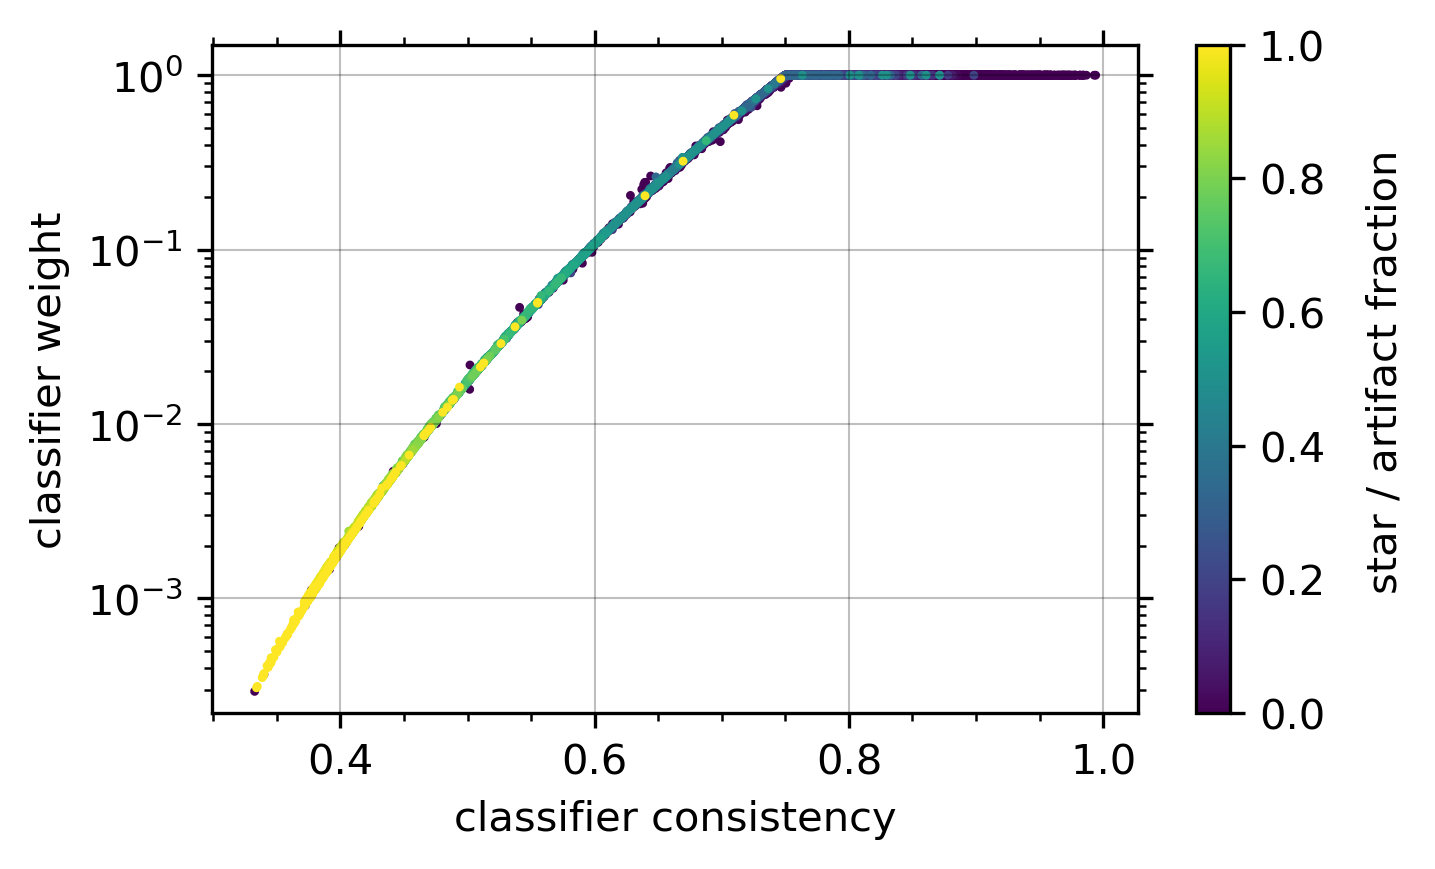

In [32]:
# consistency weight plot
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=300)
con = eval_user['consistency']
wgt = eval_user['weight']
art = eval_user['artifact_fraction']
oo = np.argsort(art)
dat = ax.scatter(con[oo], wgt[oo], c=art[oo],
                 s = 5, marker = '.', label = '')
# ax.axvline(consistency_thresh, ls='--', c='k',
#            label='consistency threshold')
ax.grid(color='black', alpha=0.25, linewidth=0.5)
ax.set_ylim((np.min(eval_user['weight']*0.75),1.5))
ax.set_yscale('log')
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.minorticks_on()
ax.set_xlabel('classifier consistency')
ax.set_ylabel('classifier weight')
# ax.legend(loc='upper left')
plt.colorbar(dat)
plt.text(0.92, 0.57, 'star / artifact fraction', rotation=90,
         transform=fig.transFigure, ha='left', va='center')
plt.tight_layout()
plt.savefig('user_consistency_weight.png', dpi='figure')
plt.show()
plt.close()

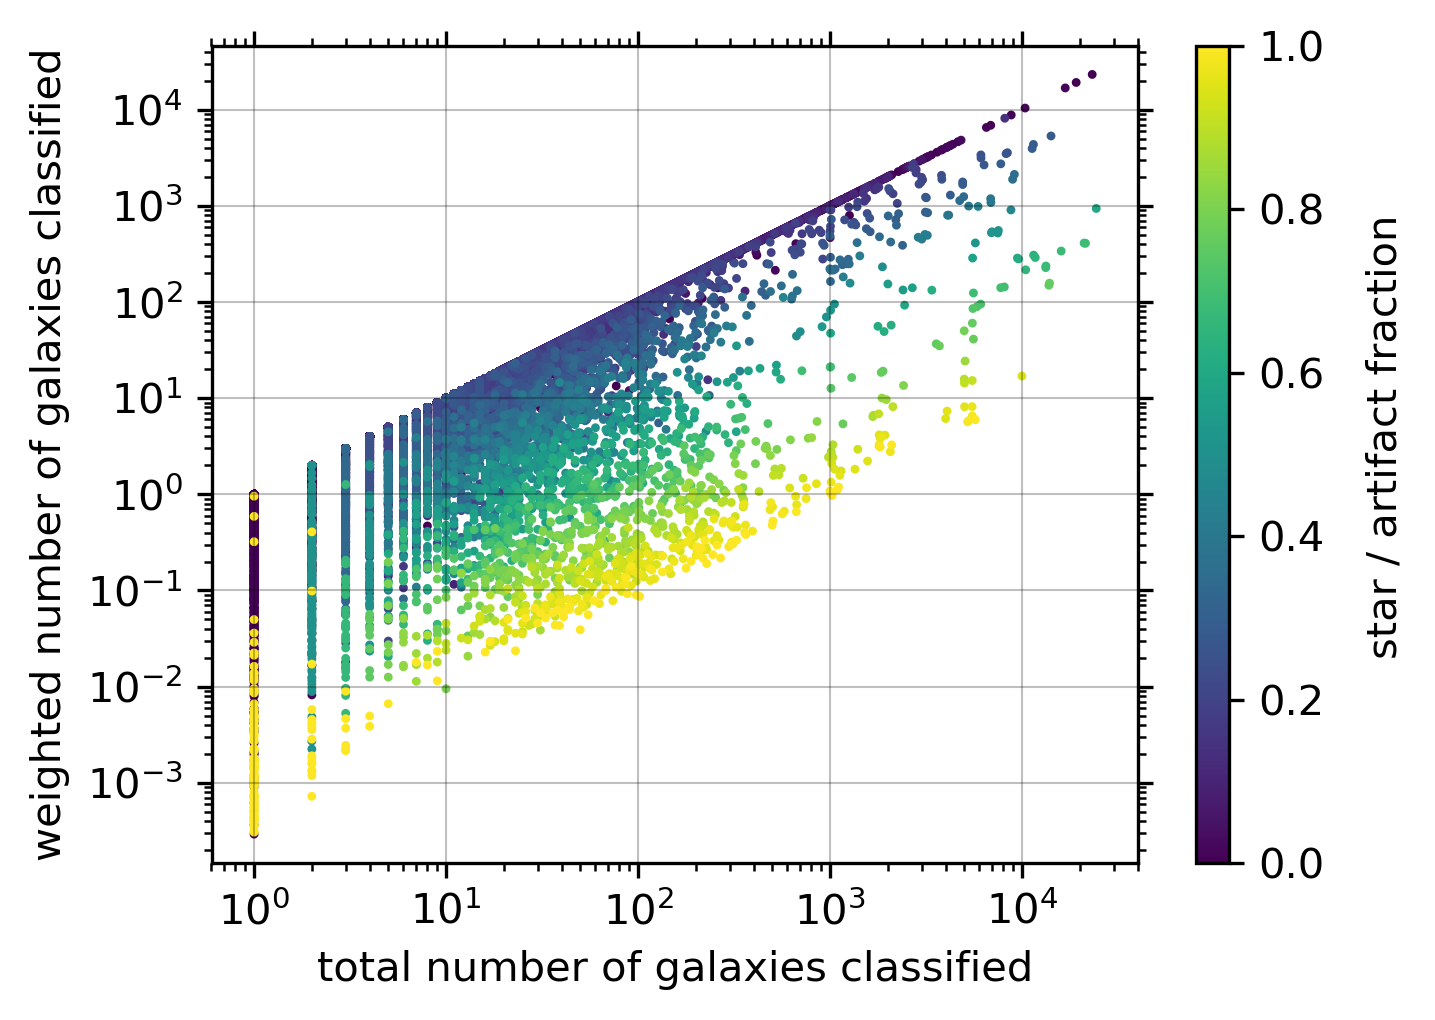

In [33]:
# unweighted count vs weighted count
fig, ax = plt.subplots(1, 1, figsize=(5,3.5), dpi=300)
c0 = eval_user['count_unweighted']
c1 = eval_user['count']
art = eval_user['artifact_fraction']
oo = np.argsort(art)
ax.scatter(c0[oo], c1[oo], c=art[oo],
           s = 5, marker = '.',)
ax.grid(color='black', alpha=0.25, linewidth=0.5)
ax.set_ylim((np.min(eval_user['count']*0.5),
             np.max(eval_user['count']*2)))
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.minorticks_on()
ax.set_xlabel('total number of galaxies classified')
ax.set_ylabel('weighted number of galaxies classified')
plt.colorbar(dat, aspect=25)
plt.text(0.92, 0.57, 'star / artifact fraction', rotation=90,
         transform=fig.transFigure, ha='left', va='center')
plt.tight_layout()
plt.savefig('user_counts.png', dpi='figure')
plt.show()
plt.close()

## Finish Up

In [34]:
# establish copies of output catalogues to be saved
bindata_out = copy.copy(bindata)
clndata_out = copy.copy(outdata)

In [35]:
# insert 'bin' into bindata total/frac column names
cols = list(bindata_out.columns)
for col in cols:
    new_col = None
    if '_total' in col:
        new_col = col.split('_total')[0] + '_bin_total'
    elif '_frac' in col:
        new_col = col.split('_frac')[0] + '_bin_frac'
    if new_col:
        bindata_out.rename_column(col, new_col)

In [36]:
# insert 'clean' into bindata total/frac column names
cols = list(clndata_out.columns)
for col in cols:
    new_col = None
    if '_total' in col:
        new_col = col.split('_total')[0] + '_clean_total'
    elif '_frac' in col:
        new_col = col.split('_frac')[0] + '_clean_frac'
    if new_col:
        clndata_out.rename_column(col, new_col)

In [37]:
# read in extra survey metadata
gama_ext = Table.read(extra_name)
if any(bindata['subject_id'] != gama_ext['subject_id']):
    raise ValueError("input catalogues must be row matched!")

In [38]:
# add extra ID names to beginning of bindata and clndata
bindata_out = hstack([gama_ext[extra_id_names], bindata_out])
clndata_out = hstack([gama_ext[extra_id_names], clndata_out])

In [39]:
# write results to disk
if save_outputs:
    outnames = [binned_name, user_weights_name, cleaned_name]
    outtabs = [bindata_out, eval_user, clndata_out]
    for outname, outtab in zip(outnames, outtabs):
        if outname[-3:] == '.gz':
            outname_TEMP = outname[:-3]
            if os.path.exists(outname_TEMP):
                os.remove(outname_TEMP)
            if os.path.exists(outname):
                os.remove(outname)
            outtab.write(outname_TEMP, format='fits')
            cmd = f'gzip --best {outname_TEMP}'
            !{cmd}
        else:
            if os.path.exists(outname):
                os.remove(outname)
            outtab.write(outname, format='fits')

In [40]:
# Notebook finish up
nbt1, nbt1str = timecheck(nbt0)
print(f'Notebook end time:\n   {nbt1str}')
#--------------------------------68-------------------------------->

Notebook end time:
   2020-10-27 17:05:29 CDT (elapsed: 01:04:24)
